## Data preparation and cleaning

In [1]:
import os
import cv2 
import itertools
import numpy as np 
import pandas as pd 

test_dir = "AlzheimerDataset/test/"
train_dir = "AlzheimerDataset/train/"

data = []

In [2]:
for dirtrain in os.listdir(train_dir): 
    print(dirtrain)
    for tr in os.listdir(train_dir + dirtrain):
        img = cv2.imread(train_dir + dirtrain + "/" + tr)
        img = cv2.resize(img, (32, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.reshape(32, 32, 1)
        
        data.append([img, dirtrain])        

MildDemented
ModerateDemented
NonDemented
VeryMildDemented


In each iteration we:
- read image
- resize the image to matrix of 32x32
- grayscaling image
- reshape the image to 3D with one color channel (Gray)
- append each image with label to the data list

In [3]:
for dirtest in  os.listdir(test_dir):    
    print(dirtest)
    for ts in os.listdir(test_dir + dirtest):
        img = cv2.imread(test_dir + dirtest + "/" + ts)
        img = cv2.resize(img, (32, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.reshape(32, 32, 1)
        
        data.append([img, dirtest])

MildDemented
ModerateDemented
NonDemented
VeryMildDemented


We do the same for the test data.

In [4]:
import random
random.seed(20)

In [5]:
random.shuffle(data)

We then shuffle the data randomly.

In [6]:
x, y = [], []
for e in data:
    x.append(e[0])
    y.append(e[1])

We split the data to images in a list and labels in another list.

In [7]:
from sklearn.preprocessing import OneHotEncoder

x = np.array(x)
y = np.array(y)
y = y.reshape(y.shape[0],1)
enc = OneHotEncoder(handle_unknown='ignore').fit(y)
print(enc.categories_)
y = enc.transform(y).toarray()
print(f'Data   :   {str(x.shape)}')
print(f'Labels :   {str(y.shape)}')

[array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')]
Data   :   (6400, 32, 32, 1)
Labels :   (6400, 4)


We encode the labels using one-hot encoding. The encoder creates a new column for each label and assigns a 1 or 0 to the column. This is to avoid the model to assume a natural ordering between categories.

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.2)

We then split the data into training and validation sets. We use 80% of the data for training and 20% for validation. 

In [9]:
import tensorflow as tf

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))

[]


Activate the GPU to accelerate the training process. We are running the notebook on Kaggle for training and prediction so the GPU are listed from Kaggle.

## Building the Model

In [11]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (4, 4), padding='same', activation=tf.nn.relu, 
    input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)), Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.3),

    tf.keras.layers.Conv2D(128, (2,2), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.3),

    tf.keras.layers.Conv2D(256, (2,2), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.3),
                    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4,  activation=tf.nn.softmax)
])

c:\Users\vikra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In the above cell we define the model architecture. We use the Sequential model from Keras. The model is a stack of layers where each layer has exactly one input tensor and one output tensor. We use the following layers:
- Conv2D: 2D convolution layer (e.g. spatial convolution over images).
- MaxPooling2D: Max pooling operation for spatial data.

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,932 (1.73 MB)

 Trainable params: 452,932 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


We now plot the model architecture. We can see the layers and the number of parameters in each layer. The number of parameters is the number of weights in each layer. The weights are the values that the model learns during training.

In [14]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
hist = model.fit(x_train, y_train, epochs=100, validation_split=0.2, batch_size=64,verbose=1,shuffle=True)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.4159 - loss: 5.0287 - val_accuracy: 0.5176 - val_loss: 1.1536
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.4750 - loss: 1.0552 - val_accuracy: 0.5176 - val_loss: 1.1170
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.4843 - loss: 1.0459 - val_accuracy: 0.5762 - val_loss: 1.0932
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.4886 - loss: 1.0052 - val_accuracy: 0.5879 - val_loss: 0.9945
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5075 - loss: 0.9863 - val_accuracy: 0.5869 - val_loss: 0.9464
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.5077 - loss: 0.9562 - val_accuracy: 0.5879 - val_loss: 0.9685
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5305 - loss: 0.9465 - val_accuracy: 0.5010 - val_loss: 1.0932
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5191 - loss: 0.9602 - val_accuracy: 0.

We start training the model with an epoch of 100. We use the Adam optimizer and the categorical crossentropy loss function. We also use the accuracy metric to measure the performance of the model.

## Plotting the training and validation accuracy

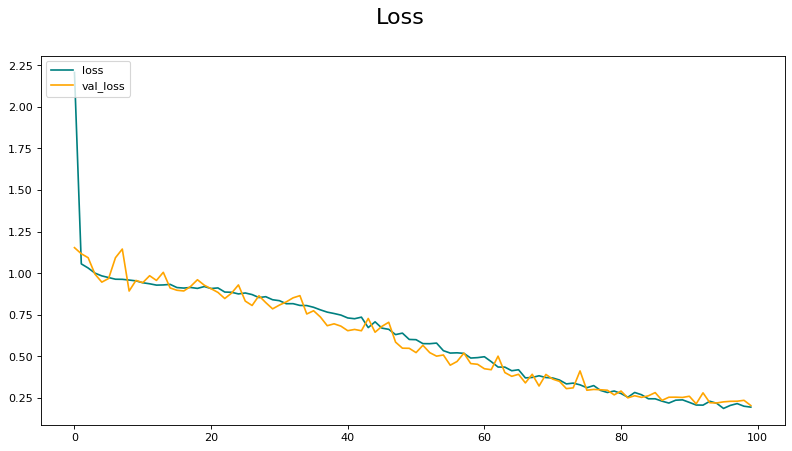

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(12, 6), dpi=80)
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

We plot the loss of training. We can see that the loss is decreasing with each epoch. We can also see that the validation loss is decreasing with each epoch. This means that the model is not overfitting the training data.

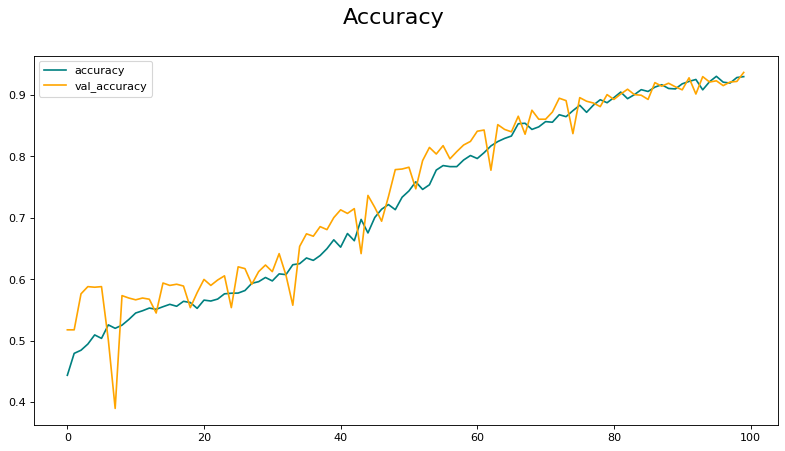

In [16]:
fig = plt.figure(figsize=(12, 6), dpi=80)
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

We then plot the accuracy of training. We can see that the accuracy is increasing with each epoch.

## Evaluating the model

In [17]:
loss_and_metrics = model.evaluate(x_test, y_test, verbose=2)
y_pred = model.predict(x_test).argmax(axis=1)
print(f'Test Loss     : {loss_and_metrics[0]}')
print(f'Test Accuracy : {loss_and_metrics[1]}')

40/40 - 1s - 33ms/step - accuracy: 0.9289 - loss: 0.2032
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Test Loss     : 0.20322799682617188
Test Accuracy : 0.928906261920929


We predict the labels of the validation set. We then calculate the accuracy of the model by comparing the predicted labels with the actual labels and print the accuracy and loss of the model.

In [18]:
from sklearn import metrics

df = pd.DataFrame(
  data = metrics.confusion_matrix(np.argmax(y_test, axis=1), y_pred),
  columns = ['0', '1', '2', '3'],
  index = ['0', '1', '2', '3']
)
df

,0,1,2,3
0,149,0,15,14
1,0,13,0,0
2,2,0,638,17
3,3,0,40,389


<Axes: >

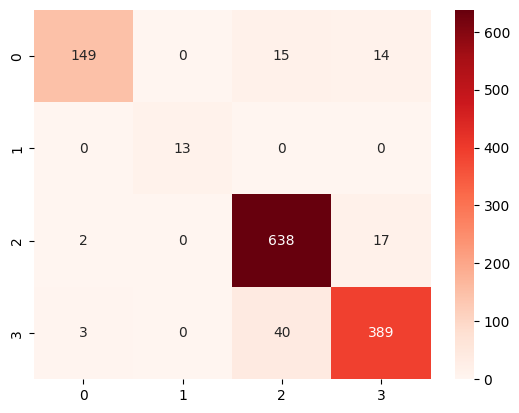

In [19]:
import seaborn as sns

sns.heatmap(df, cmap="Reds", annot=True, fmt='.0f')

We then plot the confusion matrix. The confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. We can see from the confusion matrix that the model is performing well.